# Climate change Text Classification

In [2]:
import pandas as pd
import json
import urllib.request # Import the urllib.request module

# URL of the JSONL file
url = "https://www.sustainablefinance.uzh.ch/dam/jcr:df02e448-baa1-4db8-921a-58507be4838e/climate-fever-dataset-r1.jsonl"

# Function to read the JSONL file line by line
def read_jsonl_from_url(url):
    data = []
    with urllib.request.urlopen(url) as response:
        for line in response:
            data.append(json.loads(line.decode('utf-8')))
    return data

# Load the data into a pandas DataFrame
df = pd.DataFrame(read_jsonl_from_url(url))


In [3]:
!pip install transformers datasets torch


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Display the DataFrame
df.head()

,claim_id,claim,claim_label,evidences
0,0,Global warming is driving polar bears toward e...,SUPPORTS,[{'evidence_id': 'Extinction risk from global ...
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,"[{'evidence_id': 'Famine:386', 'evidence_label..."
2,6,The polar bear population has been growing.,REFUTES,"[{'evidence_id': 'Polar bear:1332', 'evidence_..."
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,"[{'evidence_id': 'Atmosphere of Mars:131', 'ev..."
4,10,Human additions of CO2 are in the margin of er...,REFUTES,[{'evidence_id': 'Carbon dioxide in Earth's at...


In [5]:
print(df.describe())

       claim_id                                              claim  \
count      1535                                               1535   
unique     1535                                               1535   
top           0  Global warming is driving polar bears toward e...   
freq          1                                                  1   

       claim_label                                          evidences  
count         1535                                               1535  
unique           4                                               1534  
top       SUPPORTS  [{'evidence_id': 'Greenland ice sheet:43', 'ev...  
freq           654                                                  2  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1535 entries, 0 to 1534
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claim_id     1535 non-null   object
 1   claim        1535 non-null   object
 2   claim_label  1535 non-null   object
 3   evidences    1535 non-null   object
dtypes: object(4)
memory usage: 48.1+ KB
None


In [7]:
print(df.shape)

(1535, 4)


In [8]:
df.value_counts("claim_label")

claim_label
SUPPORTS           654
NOT_ENOUGH_INFO    474
REFUTES            253
DISPUTED           154
dtype: int64

# Start your project here.

## Question 1 : Dividing data into 85% train_set and 15% validation set

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Select only the columns of interest
df = df[['claim', 'claim_label']]

# Map claim_label to numeric values
label_mapping = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}
df['claim_label'] = df['claim_label'].map(label_mapping)

# Perform a stratified train-test split to ensure class balance
train_df, val_df = train_test_split(
    df,
    test_size=0.15,  # 15% for validation
    stratify=df['claim_label'],  # Ensure balanced distribution of labels
    random_state=42  # For reproducibility
)

# Verify the distribution in each split
print("Train set distribution:")
print(train_df['claim_label'].value_counts(normalize=True))

print("\nValidation set distribution:")
print(val_df['claim_label'].value_counts(normalize=True))

# Save the splits to CSV files (optional)
train_df.to_csv('train_set.csv', index=False)
val_df.to_csv('validation_set.csv', index=False)
print("\nTrain and validation sets saved as 'train_set.csv' and 'validation_set.csv'.")


Train set distribution:
0    0.425613
2    0.309049
1    0.164877
3    0.100460
Name: claim_label, dtype: float64

Validation set distribution:
0    0.428571
2    0.307359
1    0.164502
3    0.099567
Name: claim_label, dtype: float64

Train and validation sets saved as 'train_set.csv' and 'validation_set.csv'.


Now we have our train and validation set in a csv format

In [10]:
df.head()

,claim,claim_label
0,Global warming is driving polar bears toward e...,0
1,The sun has gone into ‘lockdown’ which could c...,0
2,The polar bear population has been growing.,1
3,Ironic' study finds more CO2 has slightly cool...,1
4,Human additions of CO2 are in the margin of er...,1


## Question 2 : Train a simple RNN model

### Tokenization and preprocessing

In [12]:
!pip install nltk
from nltk.corpus import stopwords
import re
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords', quiet=True)

# Define the cleaning function
def cleaning(text):
    stop = set(stopwords.words("english"))  # Use a set for faster lookup
    # Remove non-alphabetic characters and convert to lowercase
    words = re.sub(r'[^a-zA-Z]', ' ', text).lower().split()
    # Remove stopwords
    cleaned_words = [word for word in words if word not in stop]
    return cleaned_words

# Preprocess the "claim" column
df["clean"] = df["claim"]

# Apply the cleaning function to the "clean" column
df["clean"] = df["clean"].apply(cleaning)

# Display an example for verification
print("Original claim:", df["claim"][1])
print("Cleaned claim:", df["clean"][1])



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 1.5/1.5 MB 8.0 MB/s eta 0:00:00
Original claim: The sun has gone into ‘lockdown’ which could cause freezing weather, earthquakes and famine, say scientists
Cleaned claim: ['sun', 'gone', 'lockdown', 'could', 'cause', 'freezing', 'weather', 'earthquakes', 'famine', 'say', 'scientists']


In [ ]:
df.head()


,claim,claim_label,clean
0,Global warming is driving polar bears toward e...,0,"[global, warming, driving, polar, bears, towar..."
1,The sun has gone into ‘lockdown’ which could c...,0,"[sun, gone, lockdown, could, cause, freezing, ..."
2,The polar bear population has been growing.,1,"[polar, bear, population, growing]"
3,Ironic' study finds more CO2 has slightly cool...,1,"[ironic, study, finds, co, slightly, cooled, p..."
4,Human additions of CO2 are in the margin of er...,1,"[human, additions, co, margin, error, current,..."


### Encoding + training wtih RNN


In [14]:
!pip install tensorflow
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

# Verify that TensorFlow is using the GPU
if tf.config.list_physical_devices('GPU'):
    print("Running on GPU!")
else:
    print("No GPU detected. Ensure TensorFlow is set up with CUDA.")

# Parameters
max_vocab_size = 10000  # Maximum vocabulary size
max_sequence_length = 100  # Maximum sequence length
embedding_dim = 50  # Embedding dimensions

# Tokenize and pad the text data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["claim"])
sequences = tokenizer.texts_to_sequences(df["claim"])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Prepare labels
labels = df["claim_label"].values
num_classes = len(set(labels))  # Number of unique classes
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Train-validation split
train_size = int(0.85 * len(padded_sequences))
X_train, X_val = padded_sequences[:train_size], padded_sequences[train_size:]
y_train, y_val = labels[:train_size], labels[train_size:]

# Build the RNN model
with tf.device('/GPU:0'):  # Force execution on GPU
    model = Sequential([
        Embedding(max_vocab_size, embedding_dim, input_length=max_sequence_length),
        SimpleRNN(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
with tf.device('/GPU:0'):  # Force execution on GPU
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

# Display training and validation accuracy
print("\nTraining accuracy: {:.2f}%".format(100 * history.history['accuracy'][-1]))
print("Validation accuracy: {:.2f}%".format(100 * history.history['val_accuracy'][-1]))


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


No GPU detected. Ensure TensorFlow is set up with CUDA.


ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 100}

No GPU detected. Ensure TensorFlow is set up with CUDA.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3432 - loss: 1.7998 - val_accuracy: 0.4286 - val_loss: 1.6040 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.4166 - loss: 1.5749 - val_accuracy: 0.4286 - val_loss: 1.4895 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.4018 - loss: 1.4831 - val_accuracy: 0.4286 - val_loss: 1.4202 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4119 - loss: 1.4241 - val_accuracy: 0.4286 - val_loss: 1.3676 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.4036 - loss: 1.3736 - val_accuracy: 0.4286 - val_loss: 1.3372 - learning_rate: 0.0010
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.4352 - loss: 1.3607 - val_accuracy: 0.4286 - val_loss: 1.3218 - learning_rate: 0.0010
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.4377 - loss: 1.3113 - val_accuracy: 0.

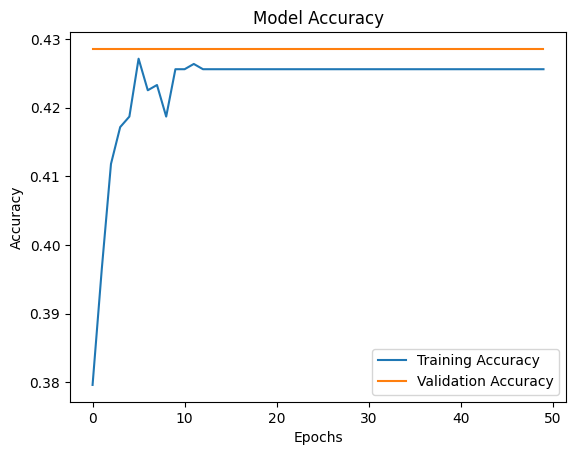

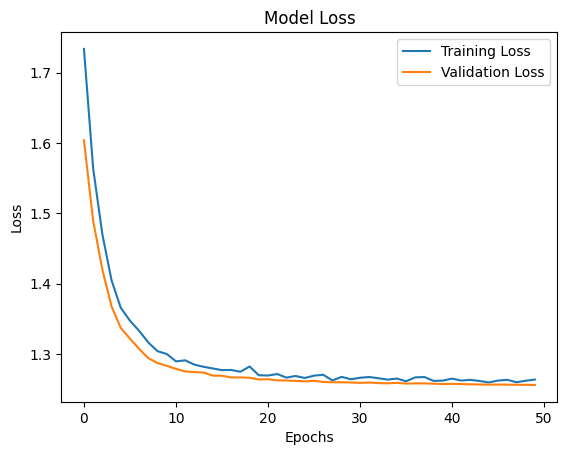

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Verify GPU availability
if tf.config.list_physical_devices('GPU'):
    print("Running on GPU!")
else:
    print("No GPU detected. Ensure TensorFlow is set up with CUDA.")

# Parameters
max_vocab_size = 10000  # Maximum vocabulary size
max_sequence_length = 100  # Maximum sequence length
embedding_dim = 100  # Embedding dimensions
dropout_rate = 0.5  # Dropout rate
l2_lambda = 0.01  # L2 regularization factor

# Use the "clean" column (already tokenized and processed)
df["clean_joined"] = df["clean"].apply(lambda x: " ".join(x))

# Tokenize and pad the text data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_joined"])  # Use the cleaned text
sequences = tokenizer.texts_to_sequences(df["clean_joined"])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Prepare labels
labels = df["claim_label"].values
num_classes = len(set(labels))  # Number of unique classes
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels, test_size=0.15, random_state=42, stratify=labels
)

# Build the model
with tf.device('/GPU:0'):  # Use GPU
    model = Sequential([
        Embedding(max_vocab_size, embedding_dim, input_length=max_sequence_length, trainable=True),
        LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda))
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Start with 50 epochs, increase if necessary
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[lr_scheduler]
)

# Display training and validation accuracy
print("\nTraining accuracy: {:.2f}%".format(100 * history.history['accuracy'][-1]))
print("Validation accuracy: {:.2f}%".format(100 * history.history['val_accuracy'][-1]))

# Plot accuracy and loss
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
max_vocab_size = 10000
max_sequence_length = 100
embedding_dim = 50
hidden_dim = 16
num_classes = len(set(df["claim_label"]))
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Tokenize and pad the text data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["claim"])
sequences = tokenizer.texts_to_sequences(df["claim"])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Prepare labels
labels = df["claim_label"].values
labels = np.eye(num_classes)[labels]  # One-hot encode the labels

# Convert data to PyTorch tensors
X = torch.tensor(padded_sequences, dtype=torch.float32).to(device)
y = torch.tensor(labels, dtype=torch.float32).to(device)

# Train-validation split
train_size = int(0.85 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Adjusted DRQN for Text Data
class DRQN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=1):
        super(DRQN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x, hidden):
        x = self.embedding(x.long())  # Convert to embeddings
        lstm_out, new_hidden = self.lstm(x, hidden)
        h = F.relu(self.fc1(lstm_out[:, -1, :]))  # Use the last output of LSTM
        out = self.fc2(h)
        return out, new_hidden

# Initialize the model
model = DRQN(vocab_size=max_vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        # Dynamically initialize hidden state based on the current batch size
        current_batch_size = batch_X.size(0)
        hidden = (
            torch.zeros(1, current_batch_size, hidden_dim).to(device),
            torch.zeros(1, current_batch_size, hidden_dim).to(device)
        )

        # Forward pass
        outputs, hidden = model(batch_X, hidden)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in val_loader:
            # Dynamically initialize hidden state for validation
            current_batch_size = batch_X.size(0)
            hidden = (
                torch.zeros(1, current_batch_size, hidden_dim).to(device),
                torch.zeros(1, current_batch_size, hidden_dim).to(device)
            )

            outputs, hidden = model(batch_X, hidden)
            loss = criterion(outputs, batch_y.argmax(dim=1))
            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y.argmax(dim=1)).sum().item()
            total += batch_y.size(0)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, "
          f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / total:.2f}")

print("Training complete!")


Epoch 1/10, Loss: 1.3102, Validation Loss: 1.2388, Accuracy: 0.43
Epoch 2/10, Loss: 1.2585, Validation Loss: 1.2324, Accuracy: 0.43
Epoch 3/10, Loss: 1.2579, Validation Loss: 1.2328, Accuracy: 0.43
Epoch 4/10, Loss: 1.2589, Validation Loss: 1.2320, Accuracy: 0.43
Epoch 5/10, Loss: 1.2565, Validation Loss: 1.2335, Accuracy: 0.43
Epoch 6/10, Loss: 1.2563, Validation Loss: 1.2329, Accuracy: 0.43
Epoch 7/10, Loss: 1.2563, Validation Loss: 1.2326, Accuracy: 0.43
Epoch 8/10, Loss: 1.2576, Validation Loss: 1.2329, Accuracy: 0.43
Epoch 9/10, Loss: 1.2579, Validation Loss: 1.2339, Accuracy: 0.43
Epoch 10/10, Loss: 1.2568, Validation Loss: 1.2329, Accuracy: 0.43
Training complete!


##

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

# Load a pretrained tokenizer
model_name = "bert-base-uncased"  # Replace with any model you prefer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["claim"], padding="max_length", truncation=True)

# Convert the dataframe to a Hugging Face Dataset
dataset = Dataset.from_pandas(df[["claim", "claim_label"]])
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Train-validation split
train_test = tokenized_dataset.train_test_split(test_size=0.15, seed=42)
train_dataset = train_test["train"]
val_dataset = train_test["test"]

# Load a pretrained model
num_classes = len(set(df["claim_label"]))
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# Define training arguments
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    eval_strategy="epoch",          # Evaluate after each epoch (updated from evaluation_strategy)
    save_strategy="epoch",          # Save model after each epoch to match eval_strategy
    learning_rate=2e-5,             # Learning rate
    per_device_train_batch_size=16, # Batch size for training
    per_device_eval_batch_size=64,  # Batch size for evaluation
    num_train_epochs=5,             # Number of epochs
    weight_decay=0.01,              # Weight decay
    logging_dir="./logs",           # Directory for logs
    logging_steps=10,
    save_total_limit=2,             # Save only the 2 most recent checkpoints
    load_best_model_at_end=True,    # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use eval_loss to determine the best model
    greater_is_better=False,        # Lower eval_loss is better
)

# Define a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-36e3d03fcd8e>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
